In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from pulearn import WeightedElkanotoPuClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import warnings

# Ignore the "DeprecationWarning" warning
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [2]:
local_stringdb = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/string/lfs-stringdb/'
# load local STRING database and names
stringdf = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
stringdf['preferred_name'] = stringdf['preferred_name'].str.upper()
stringId2name = stringdf.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = stringdf.set_index('preferred_name')['#string_protein_id'].to_dict()
stringdf = pd.read_csv(local_stringdb+'9606.protein.aliases.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
stringdf['alias'] = stringdf['alias'].str.upper()
aliases2stringId = stringdf.set_index('alias')['#string_protein_id'].to_dict()

In [9]:
def get_df(dataset):

    files_path = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/models/Dataset-'+dataset+'--RE-True--W-True--Epochs-15000--D-4--RH-25--LR-0.1--LP-False--CUDA-True/'
    path1 = files_path + 'latent.pkl'
    path2 = files_path + 'RE.pkl'

    with open(path1, 'rb') as file:
        latent = pickle.load(file)
    latent = np.array(latent)
    with open(path2, 'rb') as file:
        re = pickle.load(file)
    re = np.array(re)

    convertpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/datasets/'+dataset+'/ppi_index.pkl'
    with open(convertpath, 'rb') as file:
        ppi_index = pickle.load(file)
    data = np.concatenate((latent, re[:, np.newaxis]), axis=1)
    df_latent = pd.DataFrame()
    for i, d in enumerate(range(data.shape[1])):
        if i == len(range(data.shape[1]))-1:
            col_name = 're'
        else:
            col_name = str(d+1)+'d'
        df_latent[col_name] = data.T[d]
    df_latent['node'] = df_latent.index
    inv_dict = {v: k for k, v in ppi_index.items()}
    df_latent = df_latent.add_prefix(dataset+'_')
    df_latent['gene'] = df_latent[dataset+'_node'].map(inv_dict)
    df = df_latent.loc[:, ~df_latent.columns.str.endswith('node')]
    return df
def test_methods(X,y,rm_id):
    f1s = []
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rm_id)

    # Fit the WeightedElkanotoPuClassifier with SVC estimator on the training set
    svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
    pu_estimator = WeightedElkanotoPuClassifier(estimator=svc, labeled=10, unlabeled=20)
    pu_estimator.fit(X_train, y_train)

    # Predict the labels of the test set
    y_pred = pu_estimator.predict(X_test)
    # Calculate the f1-score of the positive class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("SVC_PU F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    # Calculate the f1-score of the positive class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("SVC F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])

    rf = RandomForestClassifier(
                n_estimators=100,
                criterion='gini',
                bootstrap=True,
                n_jobs=1,
            )

    # Create the weighted Elkanoto-PU classifier
    pu_estimator = WeightedElkanotoPuClassifier(estimator=rf, labeled=10, unlabeled=20)
    pu_estimator.fit(X_train, y_train)
    y_pred = pu_estimator.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("RF_PU F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # Calculate the f1-score of the positive class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("RF F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])
    return f1s


In [4]:
ppidf = get_df('ppi')
scdf = get_df('sc')
stdf = get_df('st')
df = pd.merge(ppidf,scdf,on='gene')
df = pd.merge(df,stdf,on='gene')
print(len(ppidf),len(scdf),len(stdf),len(df))

18767 16773 17121 15298


In [5]:
df5 = pd.read_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/DGE/selected/Coronary plaques (Anabios)_Plaque_vs_Healthy.txt', sep='\t')

In [159]:
for dgedf in [df1,df2,df3,df4,df5]:
    genes = dgedf['gene']
    genes = genes.map(aliases2stringId)
    genes =  genes.map(stringId2name)
    print(len(set(genes.tolist())&set(ppidf['gene'].tolist())),len(set(genes.tolist())&set(pos_genes)))

13713 1270
13531 1272
13531 1272
13531 1272
15071 1375


In [160]:
len(set(ppidf['gene'].tolist())&set(pos_genes))

1515

In [50]:
# root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/disease/'
# disease_source = 'OT_CAD'
# diseasedf = pd.read_csv(root+disease_source+'.tsv',sep='\t')
# pos_genes = diseasedf['symbol']
# pos_genes = pos_genes.map(aliases2stringId)
# pos_genes =  pos_genes.map(stringId2name)
# print(len(diseasedf),len(pos_genes))
# df['label'] = df['gene'].apply(lambda x: 1 if x in pos_genes.to_list() else -1)

1690 1690


In [6]:
root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/disease/'
disease_source = 'DIS_CAD'
diseasedf = pd.read_csv(root+disease_source+'.tsv',sep='\t')
pos_genes = diseasedf['Gene']
pos_genes = pos_genes.map(aliases2stringId)
pos_genes =  pos_genes.map(stringId2name)
print(len(diseasedf),len(pos_genes))
df['label'] = df['gene'].apply(lambda x: 1 if x in pos_genes.to_list() else -1)

1708 1708


In [121]:
len(set(pos_genes))

1520

In [7]:
print(len(set(pos_genes)&set(ppidf['gene'].tolist())),len(set(pos_genes)&set(scdf['gene'].tolist())),len(set(pos_genes)&set(stdf['gene'].tolist())))

1515 1433 1425


In [32]:
df.columns

Index(['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re', 'gene', 'sc_1d',
       'sc_2d', 'sc_3d', 'sc_4d', 'sc_re', 'st_1d', 'st_2d', 'st_3d', 'st_4d',
       'st_re', 'label'],
      dtype='object')

In [15]:
avg_f1 = np.empty((4,4))
avg_f1.shape

(4, 4)

In [16]:
avg_f1 = np.empty((4,4))
for rm_id in [65,227,78,17,49]:
       results = []
       X = df[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re','sc_1d',
              'sc_2d', 'sc_3d', 'sc_4d', 'sc_re', 'st_1d', 'st_2d', 'st_3d', 'st_4d',
              'st_re']].to_numpy()
       y = df['label'].to_numpy()
       print(len(np.where(y == 1.)[0]),len(np.where(y == -1.)[0]))
       print('________________ all info')
       results.append(test_methods(X,y,rm_id))
       print('________________ only ppi')
       X = df[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re']].to_numpy()
       results.append(test_methods(X,y,rm_id))
       print('________________ only sc')
       X = df[['sc_1d','sc_2d', 'sc_3d', 'sc_4d', 'sc_re']].to_numpy()
       results.append(test_methods(X,y,rm_id))
       print('________________ only st')
       X = df[['st_1d', 'st_2d', 'st_3d', 'st_4d','st_re']].to_numpy()
       results.append(test_methods(X,y,rm_id))
       results = np.array(results)
       avg_f1 += results
avg_f1 = avg_f1/5

1361 13937
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1361 13937
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1361 13937
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1361 13937
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1361 13937
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [17]:
data = np.array(avg_f1)
results_df = pd.DataFrame({'svcpu':data[0],'svc':data[1],'rfpu':data[2],'rf':data[3]})
results_df['data'] = ['all','ppi','sc','st']

In [18]:
results_df

,svcpu,svc,rfpu,rf,data
0,0.158264,0.158264,1.583639e-01,1.584106e-01,all
1,0.159054,0.208731,1.386582e-310,1.386522e-310,ppi
2,0.161737,0.175370,1.592548e-01,1.580148e-01,sc
3,0.078884,0.168247,1.386522e-310,1.386583e-310,st


In [19]:
scdf = get_df('sc_t3')
stdf = get_df('st_t3')
df = pd.merge(ppidf,scdf,on='gene')
df = pd.merge(df,stdf,on='gene')
print(len(ppidf),len(scdf),len(stdf),len(df))

18767 16146 17121 14813


In [20]:
root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/disease/'
disease_source = 'DIS_CAD'
diseasedf = pd.read_csv(root+disease_source+'.tsv',sep='\t')
pos_genes = diseasedf['Gene']
pos_genes = pos_genes.map(aliases2stringId)
pos_genes =  pos_genes.map(stringId2name)
print(len(diseasedf),len(set(pos_genes)))
df['label'] = df['gene'].apply(lambda x: 1 if x in pos_genes.to_list() else -1)

1708 1520


In [21]:
df.columns

Index(['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re', 'gene', 'sc_t3_1d',
       'sc_t3_2d', 'sc_t3_3d', 'sc_t3_4d', 'sc_t3_re', 'st_t3_1d', 'st_t3_2d',
       'st_t3_3d', 'st_t3_4d', 'st_t3_re', 'label'],
      dtype='object')

In [24]:

avg_f1_t3 = np.empty((4,4))
for rm_id in [65,227,78,17,49]:
       results = []
       X = df[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re', 'sc_t3_1d',
              'sc_t3_2d', 'sc_t3_3d', 'sc_t3_4d', 'sc_t3_re', 'st_t3_1d', 'st_t3_2d',
              'st_t3_3d', 'st_t3_4d', 'st_t3_re']].to_numpy()
       y = df['label'].to_numpy()
       print(len(np.where(y == 1.)[0]),len(np.where(y == -1.)[0]))
       print('________________ all info')
       results.append(test_methods(X,y,rm_id))
       print('________________ only ppi')
       X = df[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re']].to_numpy()
       results.append(test_methods(X,y,rm_id))
       print('________________ only sc')
       X = df[['sc_t3_1d',
              'sc_t3_2d', 'sc_t3_3d', 'sc_t3_4d', 'sc_t3_re']].to_numpy()
       results.append(test_methods(X,y,rm_id))
       print('________________ only st')
       X = df[['st_t3_1d', 'st_t3_2d',
              'st_t3_3d', 'st_t3_4d', 'st_t3_re']].to_numpy()
       results.append(test_methods(X,y,rm_id))
       results = np.array(results)
       avg_f1_t3 += results
avg_f1_t3 = avg_f1_t3/5

1334 13479
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1334 13479
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1334 13479
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1334 13479
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

1334 13479
________________ all info


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only ppi


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________ only sc


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

________________ only st


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [147]:
#OT_results = results

In [25]:
data = avg_f1_t3
results_df2 = pd.DataFrame({'svcpu':data[0],'svc':data[1],'rfpu':data[2],'rf':data[3]})
results_df2['data'] = ['all','ppi','sct3','stt3']

In [26]:
results_df2

,svcpu,svc,rfpu,rf,data
0,0.194101,0.194119,1.941312e-01,1.941196e-01,all
1,0.185501,0.267160,2.773164e-311,2.773043e-311,ppi
2,0.197562,0.213752,1.943910e-01,1.949515e-01,sct3
3,0.090947,0.199730,2.948283e-03,2.773165e-311,stt3


In [152]:
results_df

,svcpu,svc,rfpu,rf,data,label
0,0.171548,0.171497,0.171497,0.171497,all,dsigenet
1,0.149758,0.207547,0.000000,0.000000,ppi,dsigenet
2,0.176782,0.190646,0.174389,0.171875,sc,dsigenet
3,0.078176,0.149254,0.000000,0.000000,st,dsigenet
4,0.228571,0.337662,0.000000,0.000000,all,ot
5,0.208955,0.361111,0.000000,0.000000,ppi,ot
6,0.194030,0.233129,0.033333,0.023256,sc,ot
7,0.117647,0.333333,0.000000,0.000000,st,ot


In [ ]:
genes = df5['gene']
genes = genes.map(aliases2stringId)
genes =  genes.map(stringId2name)
df5['gene'] = genes
dge = df5[['gene','log2FC']]
ppidge = pd.merge(ppidf,dge, on='gene',how='left')
ppidge = ppidge.fillna(dge['log2FC'].mean())
ppidge['label'] = ppidge['gene'].apply(lambda x: 1 if x in pos_genes.to_list() else -1)

In [172]:
ppidge.columns

Index(['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re', 'gene', 'log2FC',
       'label'],
      dtype='object')

In [175]:
results = []
X = ppidge[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_re', 'log2FC']].to_numpy()
y = ppidge['label'].to_numpy()
print('________________ ppi all')
results.append(test_methods(X,y))
print('________________ ppi network')
X = ppidge[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d','ppi_re']].to_numpy()
results.append(test_methods(X,y))
print('________________ ppi latent z')
X = ppidge[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d']].to_numpy()
results.append(test_methods(X,y))

________________ ppi all


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC_PU F1-score of positive class:  0.15775593382881803
SVC F1-score of positive class:  0.19354838709677422


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_PU F1-score of positive class:  0.17723669309173273
RF F1-score of positive class:  0.15176151761517614
________________ ppi network


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC_PU F1-score of positive class:  0.15790736741060715
SVC F1-score of positive class:  0.22764227642276422


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_PU F1-score of positive class:  0.17763352021245205
RF F1-score of positive class:  0.2543640897755611
________________ ppi latent z


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC_PU F1-score of positive class:  0.15786948176583493
SVC F1-score of positive class:  0.18818380743982493


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_PU F1-score of positive class:  0.18704117459304181
RF F1-score of positive class:  0.24630541871921183


In [176]:
ppidge['abs_fc'] = ppidge['log2FC'].abs()
print('________________ ppi network')
X = ppidge[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d','ppi_re','abs_fc']].to_numpy()
results.append(test_methods(X,y))

________________ ppi network


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC_PU F1-score of positive class:  0.15783161429599424
SVC F1-score of positive class:  0.1975806451612903


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_PU F1-score of positive class:  0.17657142857142857
RF F1-score of positive class:  0.13736263736263735


In [177]:
data = np.array(results)
results_df3 = pd.DataFrame({'svcpu':data[0],'svc':data[1],'rfpu':data[2],'rf':data[3]})

In [178]:
results_df3

,svcpu,svc,rfpu,rf
0,0.157756,0.157907,0.157869,0.157832
1,0.193548,0.227642,0.188184,0.197581
2,0.177237,0.177634,0.187041,0.176571
3,0.151762,0.254364,0.246305,0.137363


In [70]:
def rf_pu(X,y):
    permut = np.random.permutation(len(y))
    X = X[permut]
    y = y[permut]

    print("Loaded {} examples.".format(len(y)))
    print("{} are unknow.".format(len(np.where(y == -1.)[0])))
    print("{} are pos.".format(len(np.where(y == +1.)[0])))
    print("\nSplitting dataset into test/train sets...")
    split = int(2 * len(y) / 3)
    # Select elements from 0 to split-1 (including both ends)
    X_train = X[:split]
    y_train = y[:split]
    X_test = X[split:]  # Select elements from index select to end.
    y_test = y[split:]
    print("Training set contains {} examples.".format(len(y_train)))
    print("{} are unknow.".format(len(np.where(y_train == -1.)[0])))
    print("{} are pos.".format(len(np.where(y_train == +1.)[0])))
    pu_f1_scores = []
    reg_f1_scores = []
    # Not sure what this is? but seems like an array having numbers starting
    # from 0 to total positive examples in the train split - 21 separated by
    # intervals of 5.
    # Still not sure what the significance of 21 here is though.
    # Totally not sure what the significance of 21 here is?
    n_sacrifice_iter = range(0, len(np.where(y_train == +1.)[0]) - 21, 5)
    print(n_sacrifice_iter)
    print(len(n_sacrifice_iter))
    for n_sacrifice in n_sacrifice_iter[:-1]:
        print("PU transformation in progress...")
        print("Making {} unknow examples bening.".format(n_sacrifice))
        y_train_pu = np.copy(y_train)
        pos = np.where(y_train == +1.)[0]
        np.random.shuffle(pos)
        sacrifice = pos[:n_sacrifice]
        y_train_pu[sacrifice] = -1.
        pos = len(np.where(y_train_pu == -1.)[0])
        unlabelled = len(np.where(y_train_pu == +1.)[0])
        print("PU transformation applied. We now have:")
        print("{} are unknow.".format(len(np.where(y_train_pu == -1.)[0])))
        print("{} are pos.".format(len(np.where(y_train_pu == +1.)[0])))
        print("-------------------")
        print((
            "Fitting PU classifier (using a random forest as an inner "
            "classifier)..."
        ))
        estimator = RandomForestClassifier(
            n_estimators=100,
            criterion='gini',
            bootstrap=True,
            n_jobs=1,
        )
        pos = len(np.where(y_train == -1.)[0])
        unlabelled = len(np.where(y_train == +1.)[0])
        
        pu_estimator = WeightedElkanotoPuClassifier(estimator=rf, labeled=pos, unlabeled=unlabelled)
        print(pu_estimator)
        pu_estimator.fit(X_train, y_train_pu)
        y_pred = pu_estimator.predict(X_test)
        precision, recall, f1_score, _ = precision_recall_fscore_support(
            y_test, y_pred)
        pu_f1_scores.append(f1_score[1])
        print("F1 score: {}".format(f1_score[1]))
        print("Precision: {}".format(precision[1]))
        print("Recall: {}".format(recall[1]))
        print("Regular learning (w/ a random forest) in progress...")
        estimator = RandomForestClassifier(
            n_estimators=100,
            bootstrap=True,
            n_jobs=1,
        )
        estimator.fit(X_train, y_train_pu)
        y_pred = estimator.predict(X_test)
        precision, recall, f1_score, _ = precision_recall_fscore_support(
            y_test, y_pred)
        reg_f1_scores.append(f1_score[1])
        print("F1 score: {}".format(f1_score[1]))
        print("Precision: {}".format(precision[1]))
        print("Recall: {}".format(recall[1]))
    plt.title("Random forest with/without PU learning")
    plt.plot(n_sacrifice_iter[:-1], pu_f1_scores, label='PU Adapted Random Forest')
    plt.plot(n_sacrifice_iter[:-1], reg_f1_scores, label='Random Forest')
    plt.xlabel('Number of positive examples hidden in the unlabled set')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [73]:
rf_pu(X,y)

Loaded 15298 examples.
15082 are unknow.
216 are pos.

Splitting dataset into test/train sets...
Training set contains 10198 examples.
10071 are unknow.
127 are pos.
range(0, 106, 5)
22
PU transformation in progress...
Making 0 unknow examples bening.
PU transformation applied. We now have:
10071 are unknow.
127 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.06451612903225806
Precision: 0.75
Recall: 0.033707865168539325
PU transformation in progress...
Making 5 unknow examples bening.
PU transformation applied. We now have:
10076 are unknow.
122 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.043478260869565216
Precision: 0.6666666666666666
Recall: 0.02247191011235955
PU transformation in progress...
Making 10 unknow examples bening.
PU transformation applied. We now have:
10081 are unknow.
117 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.06315789473684211
Precision: 0.5
Recall: 0.033707865168539325
PU transformation in progress...
Making 15 unknow examples bening.
PU transformation applied. We now have:
10086 are unknow.
112 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.0425531914893617
Precision: 0.4
Recall: 0.02247191011235955
PU transformation in progress...
Making 20 unknow examples bening.
PU transformation applied. We now have:
10091 are unknow.
107 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.06451612903225806
Precision: 0.75
Recall: 0.033707865168539325
PU transformation in progress...
Making 25 unknow examples bening.
PU transformation applied. We now have:
10096 are unknow.
102 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.02222222222222222
Precision: 1.0
Recall: 0.011235955056179775
PU transformation in progress...
Making 30 unknow examples bening.
PU transformation applied. We now have:
10101 are unknow.
97 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.04395604395604395
Precision: 1.0
Recall: 0.02247191011235955
PU transformation in progress...
Making 35 unknow examples bening.
PU transformation applied. We now have:
10106 are unknow.
92 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 40 unknow examples bening.
PU transformation applied. We now have:
10111 are unknow.
87 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...
F1 score: 0.04301075268817204
Precision: 0.5
Recall: 0.02247191011235955
PU transformation in progress...
Making 45 unknow examples bening.
PU transformation applied. We now have:
10116 are unknow.
82 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 50 unknow examples bening.
PU transformation applied. We now have:
10121 are unknow.
77 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 55 unknow examples bening.
PU transformation applied. We now have:
10126 are unknow.
72 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 60 unknow examples bening.
PU transformation applied. We now have:
10131 are unknow.
67 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 65 unknow examples bening.
PU transformation applied. We now have:
10136 are unknow.
62 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 70 unknow examples bening.
PU transformation applied. We now have:
10141 are unknow.
57 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 75 unknow examples bening.
PU transformation applied. We now have:
10146 are unknow.
52 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 80 unknow examples bening.
PU transformation applied. We now have:
10151 are unknow.
47 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 85 unknow examples bening.
PU transformation applied. We now have:
10156 are unknow.
42 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 90 unknow examples bening.
PU transformation applied. We now have:
10161 are unknow.
37 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 95 unknow examples bening.
PU transformation applied. We now have:
10166 are unknow.
32 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/pulearn/elkanoto.py:220: RuntimeWarning: divide by zero encountered in scalar divide
  W = (G / (1 - G)) * ((1 - self.c) / self.c)
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/pulearn/elkanoto.py:220: RuntimeWarning: invalid value encountered in multiply
  W = (G / (1 - G)) * ((1 - self.c) / self.c)
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score 

F1 score: 0.0
Precision: 0.0
Recall: 0.0
Regular learning (w/ a random forest) in progress...


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Precision: 0.0
Recall: 0.0
PU transformation in progress...
Making 100 unknow examples bening.
PU transformation applied. We now have:
10171 are unknow.
27 are pos.
-------------------
Fitting PU classifier (using a random forest as an inner classifier)...
Estimator: RandomForestClassifier(n_jobs=1)
p(s=1|y=1,x) ~= 1.0
Fitted: False


ValueError: Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by RandomForestClassifier.

In [53]:
# Define the range of hyperparameters to search over
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the random forest classifier
rf = RandomForestClassifier()
# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
# Fit the grid search object to the data
grid_search.fit(X, y)
# Get the best hyperparameters
best_params = grid_search.best_params_


0.8


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

0.4


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2


/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/hbdm_env/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


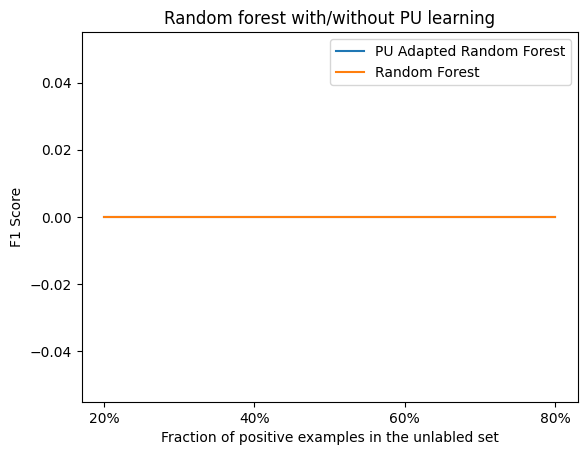

In [54]:

# Initialize lists to store precision, recall and f1 scores for each fold
precision_scores = []
recall_scores = []
f1_scores = []

rfprecision_scores = []
rfrecall_scores = []
rff1_scores = []

# define the splits to use for the training set
splits = [0.8, 0.6, 0.4, 0.2]

# iterate over the splits
for split in splits:
    print(split)
    # calculate the number of positive samples to include in the training set
    n_pos_train = int(split * len(np.where(y == 1.)[0]))
    
    # calculate the number of negative samples to include in the training set
    n_neg_train = int(0.75 * len(y)) - n_pos_train
    
    # create a boolean array to select the positive samples for the training set
    pos_mask = y == 1
    
    # create a boolean array to select the negative samples for the training set
    neg_mask = y == -1
    
    # randomly select the positive samples for the training set
    pos_train_idx = np.random.choice(np.where(pos_mask)[0], size=n_pos_train, replace=False)
    
    # randomly select the negative samples for the training set
    neg_train_idx = np.random.choice(np.where(neg_mask)[0], size=n_neg_train, replace=False)
    
    # combine the indices for the positive and negative samples in the training set
    train_idx = np.concatenate((pos_train_idx, neg_train_idx))
    
    # create the training set
    X_train = X[train_idx]
    y_train = y[train_idx]
    
    # create the testing set
    X_test = X[np.setdiff1d(np.arange(len(y)), train_idx)]
    y_test = y[np.setdiff1d(np.arange(len(y)), train_idx)]

    pos = len(np.where(y_train == -1.)[0])
    unlabelled = len(np.where(y_train == +1.)[0])

    # Create a new random forest classifier using the best hyperparameters
    rf = RandomForestClassifier(
        n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])
    # Create the weighted Elkanoto-PU classifier
    pu_estimator = WeightedElkanotoPuClassifier(estimator=rf, labeled=pos, unlabeled=unlabelled, hold_out_ratio=0.2)

    pu_estimator.fit(X_train, y_train)
    y_pred = pu_estimator.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])

    # Calculate precision, recall and f1 score for this fold and store in the lists
    precision_scores.append(precision[1])
    recall_scores.append(recall[1])
    f1_scores.append(f1_score[1])

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])

    rfprecision_scores.append(precision[1])
    rfrecall_scores.append(recall[1])
    rff1_scores.append(f1_score[1])

split_label = ['20%','40%','60%','80%']
plt.title("Random forest with/without PU learning")
plt.plot(split_label, f1_scores, label='PU Adapted Random Forest')
plt.plot(split_label, rff1_scores, label='Random Forest')
plt.xlabel('Fraction of positive examples in the unlabled set')
plt.ylabel('F1 Score')
plt.legend()
plt.show()